In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.optim import Adam
from datasets import load_dataset
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from transformers import Trainer, TrainingArguments
from copy import deepcopy
import copy
import logging
import json
from dataclasses import dataclass
import numpy
import pandas as pd
from typing import Optional, Dict, Sequence

device = "cuda" if torch.cuda.is_available() else "cpu"

print("Torch version:{}".format(torch.__version__)) # Torch version:1.12.1
print("Cuda version: {}".format(torch.version.cuda)) # Cuda version: 11.3
print("transformers version: {}".format(transformers.__version__)) # transformers 4.28.0
print("GPU 사용 가능여부: {}".format(torch.cuda.is_available()))

Torch version:1.12.1
Cuda version: 11.3
transformers version: 4.28.0
GPU 사용 가능여부: True


In [2]:
#torch.cuda.empty_cache()

In [3]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |
|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |

# 0. 전처리된 데이타 파일 로딩

In [4]:
data_save_path_SFT = './data/clean_kochatgpt_1_SFT.jsonl'

In [5]:


#with open(data_save_path_SFT, "r", encoding='utf-8-sig') as json_file:
#    sft_data_dict = json.load(json_file)

#print(len(sft_data_dict))
#sft_data_dict[:3]

# 1. KOGPT2 모델

In [16]:
model_name = "skt/kogpt2-base-v2"
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)  # GPU 또는 CPU

tokenizer = AutoTokenizer.from_pretrained(
    model_name, bos_token='</s>', eos_token='</s>', unk_token='</s>', pad_token='</s>',
    padding_side="right",
    model_max_length=512,
    #model_max_length=384,           # CUDA OOM 문제로 줄여보자!!
)
print(tokenizer)

GPT2TokenizerFast(name_or_path='skt/kogpt2-base-v2', vocab_size=51200, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '</s>', 'eos_token': '</s>', 'unk_token': '</s>', 'pad_token': '</s>'}, clean_up_tokenization_spaces=True)


In [7]:
@dataclass
class DataCollatorForSupervisedDataset(object): 

    tokenizer: transformers.PreTrainedTokenizer

    def __call__(self, instances: Sequence[Dict]) -> Dict[str, torch.Tensor]:
        input_ids, labels = tuple([instance[key] for instance in instances] for key in ("input_ids", "labels"))
        input_ids = torch.nn.utils.rnn.pad_sequence(
            input_ids, batch_first=True, padding_value=self.tokenizer.pad_token_id
        )
        # batch 내 label 시퀀스를 길이에 맞춰 패딩(padding)
        # padding_value= -100 : 짧은 시퀀스를 맞추기 위해 채울 값
        # PyTorch의 nn.CrossEntropyLoss()에서는 ignore_index=-100이 기본값
        labels = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value= -100)
        return dict(
            input_ids=input_ids,
            labels=labels,
            attention_mask=input_ids.ne(self.tokenizer.pad_token_id),
        )

In [8]:
class KoGPT_dataset(Dataset):

    def __init__(self, data_path_1_SFT: str, tokenizer: transformers.PreTrainedTokenizer, verbose=False):
        super(KoGPT_dataset, self).__init__()
        logging.warning("Loading data...")

        with open(data_path_1_SFT, "r", encoding='utf-8-sig') as json_file:
            list_data_dict = json.load(json_file)

        sources = []
        targets = []
        for example in list_data_dict:
            sources.append(example['prompt'])
            targets.append(example['completion'] + tokenizer.eos_token)
          
        examples = [s + t for s, t in zip(sources, targets)]

        # sources_tokenized는 **입력 마스킹(masking)**에 쓰이고,
        # examples_tokenized는 전체 학습 텍스트 + 레이블용 토큰이다
        sources_tokenized = self._tokenize_fn(sources, tokenizer)  # source
        examples_tokenized = self._tokenize_fn(examples, tokenizer)  # source + target

        input_ids = examples_tokenized["input_ids"]
        # loss 계산시 label을 정의하는 부분으로, input_ids를 그대로 copy하되
        # prompt 부분은 필요없으므로 lable에서 prompt 부분은 -100으로 masking한다. 
        labels = copy.deepcopy(input_ids)
        for label, source_len in zip(labels, sources_tokenized["input_ids_lens"]):
            label[:source_len] = -100
       

        data_dict = dict(input_ids=input_ids, labels=labels)

        self.input_ids = data_dict["input_ids"]
        self.labels = data_dict["labels"]
        logging.warning("Loading data done!!: %d"%(len(self.labels)))


    def _tokenize_fn(self, strings: Sequence[str], tokenizer: transformers.PreTrainedTokenizer) -> Dict:
        tokenized_list = [
            tokenizer(
                text,
                return_tensors="pt",
                padding="longest",
                max_length=tokenizer.model_max_length,
                truncation=True,
            )
            for text in strings
        ]
        input_ids = labels = [tokenized.input_ids[0] for tokenized in tokenized_list]
        input_ids_lens = labels_lens = [
            tokenized.input_ids.ne(tokenizer.pad_token_id).sum().item() for tokenized in tokenized_list
        ]
        return dict(
            input_ids=input_ids,
            labels=labels,
            input_ids_lens=input_ids_lens,
            labels_lens=labels_lens,
        )


    def __len__(self):
        return len(self.input_ids)


    def __getitem__(self, i) -> Dict[str, torch.Tensor]:
        return dict(input_ids=self.input_ids[i], labels=self.labels[i])


In [9]:
kg_train_dataset = KoGPT_dataset(data_path_1_SFT=data_save_path_SFT, tokenizer=tokenizer)
data_collator = DataCollatorForSupervisedDataset(tokenizer=tokenizer)

print(type(kg_train_dataset))
print(len(kg_train_dataset))
print('input : %s'%kg_train_dataset.input_ids[0])
print('output: %s'%kg_train_dataset.labels[0])

<class '__main__.KoGPT_dataset'>
11992
input : tensor([ 9128, 20479,  8091, 22311,  9036, 30902,  8084,   739,   406, 37767,
        13753,  8263,  7166,   739,  8352,  7659,  9639, 11481, 25585, 13600,
         8022,  9378, 11532,  9887, 11218,  9111, 16913,  7182, 36510, 10351,
        10561,  9128, 20479,  8091,  9065,  9446, 33869, 11481, 46311, 11481,
        26367,  6958,  9030,  9882, 12317, 25882,  9209,  8708,  7172,  7182,
        36510, 10351,  9036, 12168, 10529, 15989,  9719, 15434, 10552, 11188,
         9355, 11481,  9036, 15805, 11300, 11846,  9146, 16913,  7182, 36510,
         9181,  7397, 15806, 13480, 11342, 17596,  9161, 19996,  9025, 25006,
        18595,  9966, 12592, 10751, 11814,  8711,  9046, 12450,  9117,  7377,
         7172,  7182, 36510,     1])
output: tensor([ -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100, 37767,
        13753,  8263,  7166,   739,  8352,  7659,  9639, 11481, 25585, 13600,
         8022,  9378, 11532,  9887, 11218,  9111, 

In [10]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  501216 KB |  501216 KB |  501216 KB |       0 B  |
|       from large pool |  488448 KB |  488448 KB |  488448 KB |       0 B  |
|       from small pool |   12768 KB |   12768 KB |   12768 KB |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |  501216 KB |  501216 KB |  501216 KB |       0 B  |
|       from large pool |  488448 KB |  488448 KB |  488448 KB |

In [11]:
# train_dataset.input_ids[0]를 디코딩해보세요.
input_text = tokenizer.decode(kg_train_dataset.input_ids[0] , skip_special_tokens=True)
label_text = tokenizer.decode([token for token in  kg_train_dataset.labels[0]  if token != -100], skip_special_tokens=True)

print(f"[INPUT]:\n{input_text}\n")
print(f"[LABEL]:\n{label_text}\n")

[INPUT]:
불고기용 고기 한우에요?저는 인공지능 챗봇이며, 직접적으로 식품에 관한 정보를 가지고 있지 않습니다. 하지만 일반적으로 불고기용 고기는 한우, 쇠고기, 돼지고기 등 다양한 종류의 고기를 사용합니다. 하지만 한우는 대표적인 고급 육류로 알려져 있기 때문에, 한우를 사용하는 경우도 많습니다. 알러지나 개별 건강 상태에 따라 다를 수 있으니 충분한 정보 수집 후에 선택해 주시기 바랍니다.

[LABEL]:
저는 인공지능 챗봇이며, 직접적으로 식품에 관한 정보를 가지고 있지 않습니다. 하지만 일반적으로 불고기용 고기는 한우, 쇠고기, 돼지고기 등 다양한 종류의 고기를 사용합니다. 하지만 한우는 대표적인 고급 육류로 알려져 있기 때문에, 한우를 사용하는 경우도 많습니다. 알러지나 개별 건강 상태에 따라 다를 수 있으니 충분한 정보 수집 후에 선택해 주시기 바랍니다.



In [25]:
from torch.utils.data import random_split

total_len = len(kg_train_dataset)

# train 80%, val 10%, test 10%로 나누기
train_size = int(0.8 * total_len)
val_size = int(0.1 * total_len)
test_size = total_len - train_size - val_size  # 남는 거 처리

# 랜덤 시드 고정
generator = torch.Generator().manual_seed(42)
kg_train, kg_val, kg_test = random_split(kg_train_dataset, [train_size, val_size, test_size], generator=generator)


print(f"Train: {len(kg_train)}")
print(f"Validation: {len(kg_val)}")
print(f"Test: {len(kg_test)}")

Train: 9593
Validation: 1199
Test: 1200


**Metrics**

In [13]:
import math
from datasets import load_metric

def compute_metrics(eval_preds):
    logits, labels = eval_preds
    # shift so that tokens <n> predict <n+1>
    shift_logits = logits[..., :-1, :].contiguous()
    shift_labels = labels[..., 1:].contiguous()

    # Flatten for loss calculation
    loss_fct = torch.nn.CrossEntropyLoss(ignore_index=-100)
    loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
    
    # Perplexity
    perplexity = math.exp(loss.item())

    return {
        "loss": loss.item(),
        "perplexity": perplexity
    }

In [26]:
output_dir = os.getenv('HOME')+'/aiffel/KoChatGPT/test'

training_args = TrainingArguments(
    output_dir,
    overwrite_output_dir=True,
    evaluation_strategy="epoch",        #evaluation하는 빈도
    logging_strategy="epoch",           # epoch마다 로그 기록
    learning_rate = 2e-5,               #learning_rate
    num_train_epochs=1,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    warmup_steps=5,
    #prediction_loss_only=True,
    logging_dir="./kogpt_logs",
    fp16 = True
    )

trainer = Trainer(
    model=model,
    
    args=training_args,
    data_collator=data_collator,
    train_dataset=kg_train,
    eval_dataset=kg_val, 
    tokenizer=tokenizer,
    compute_metrics=compute_metrics 
)

In [ ]:
trainer.train()

/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss


In [24]:
trainer.evaluate(kg_test)

{'eval_loss': 2.3260583877563477,
 'eval_runtime': 20.2746,
 'eval_samples_per_second': 98.251,
 'eval_steps_per_second': 49.125,
 'epoch': 1.0}

In [23]:
for log in trainer.state.log_history:
    if 'eval_loss' in log:
        print(f"Step: {log.get('step')}, Epoch: {log.get('epoch')}, Eval Loss: {log.get('eval_loss')}")
    if 'loss' in log:
        print(f"Step: {log.get('step')}, Epoch: {log.get('epoch')}, Loss: {log.get('loss')}")
    if 'perplexity' in log:
        print(f"Step: {log.get('step')}, Epoch: {log.get('epoch')}, Perplexity: {log.get('perplexity')}")

Step: 5000, Epoch: 1.0, Loss: 2.5694
Step: 5000, Epoch: 1.0, Eval Loss: 2.3260583877563477


In [20]:
import matplotlib.pyplot as plt

def display_train_graph(logs) : 
    train_loss = [log["loss"] for log in logs if "loss" in log]
    steps = list(range(1, len(train_loss) + 1))
    
    eval_loss = [log["eval_loss"] for log in logs if "eval_loss" in log]
    #eval_acc = [log["eval_accuracy"] for log in logs if "eval_accuracy" in log]
    #eval_f1 = [log["eval_f1"] for log in logs if "eval_f1" in log]
    # eval_steps = list(range(1, len(eval_loss)) )
    
    # train_loss 길이에 맞춰 eval_loss, eval_acc, eval_f1 자르기
    eval_loss = eval_loss[:len(train_loss)]
    #eval_acc = eval_acc[:len(train_loss)]
    #eval_f1 = eval_f1[:len(train_loss)]
    eval_steps = steps

    # 그래프 그리기
    plt.figure(figsize=(12, 5))

    # Loss 그래프
    
    plt.plot(steps, train_loss, label="Train Loss") 
    plt.plot(steps, eval_loss, label="Val Loss", color="red")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Train Loss per Epoch")
    plt.legend()

    plt.tight_layout()
    plt.show()

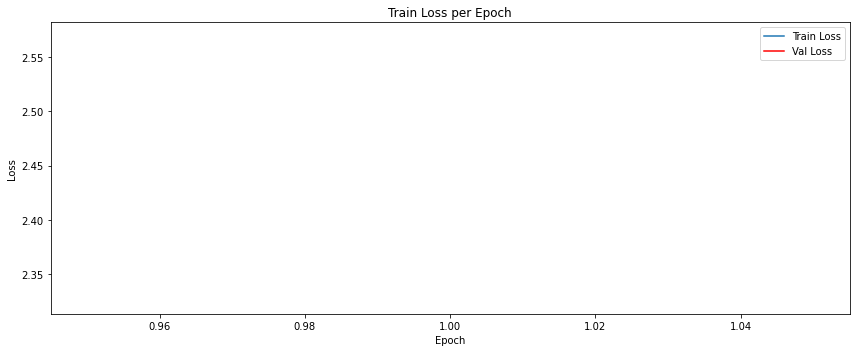

In [21]:
# 학습 후 로그 가져오기
kogpt_logs = trainer.state.log_history

display_train_graph(logs = kogpt_logs)